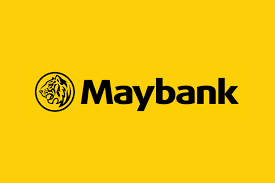

# Import Library

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df=pd.read_csv("/content/maybank_churn_dataset_v2_500k.csv")
# df.head()

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

features_to_scale = ['Balance_Funding', 'Balance_Loan', 'Balance_Wealth']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features_to_scale])

X_scaled_df = pd.DataFrame(X_scaled, columns=features_to_scale)

df_scaled = df.copy()
df_scaled[features_to_scale] = X_scaled_df

## features engeneering

In [ ]:

# Total jumlah produk
df_scaled['Total_PH'] = df_scaled['PH_Funding'] + df_scaled['PH_Loan'] + df_scaled['PH_Wealth']

# Total balance
df_scaled['Total_Balance'] = df_scaled['Balance_Funding'] + df_scaled['Balance_Loan'] + df_scaled['Balance_Wealth']

# Rasio balance tabungan ke total
df_scaled['Funding_Share'] = df_scaled['Balance_Funding'] / (df_scaled['Total_Balance'] + 1e-5)

# Rasio funding vs wealth (investasi)
df_scaled['Funding_to_Wealth_Ratio'] = df_scaled['Balance_Funding'] / (df_scaled['Balance_Wealth'] + 1e-5)

# Apakah hanya punya satu produk?
df_scaled['Is_Single_Product'] = (df_scaled[['PH_Funding', 'PH_Loan', 'PH_Wealth']].sum(axis=1) == 1).astype(int)

In [ ]:
features = ['PH_Funding', 'PH_Loan', 'PH_Wealth', 'Balance_Funding',
           'Balance_Loan', 'Balance_Wealth', 'Activeness', 'Branch',
           'Marital_Status', 'Age','Gender', 'Area','Total_PH','Total_Balance',
            'Funding_Share','Funding_to_Wealth_Ratio','Is_Single_Product']

In [ ]:
x=df_scaled[features]
y=df_scaled['Potential_Churn_2']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE


# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Terapkan SMOTE ke data training
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Sebelum SMOTE:", y_train.value_counts())
print("Setelah SMOTE:", pd.Series(y_train_res).value_counts())

# 3. Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_res, y_train_res)
y_pred_lr = lr.predict(X_test)
print("\n Logistic Regression")
print(classification_report(y_test, y_pred_lr))

# 4. Naive Bayes
nb = GaussianNB()
nb.fit(X_train_res, y_train_res)
y_pred_nb = nb.predict(X_test)
print("\n Naive Bayes")
print(classification_report(y_test, y_pred_nb))

# # 5. Random Forest
# rf = RandomForestClassifier(random_state=42)
# rf.fit(X_train_res, y_train_res)
# y_pred_rf = rf.predict(X_test)
# print("\n Random Forest")
# print(classification_report(y_test, y_pred_rf))


Sebelum SMOTE: Potential_Churn_2
0    379601
1     20399
Name: count, dtype: int64
Setelah SMOTE: Potential_Churn_2
0    379601
1    379601
Name: count, dtype: int64

 Logistic Regression
              precision    recall  f1-score   support

           0       0.95      0.51      0.67     94900
           1       0.05      0.49      0.09      5100

    accuracy                           0.51    100000
   macro avg       0.50      0.50      0.38    100000
weighted avg       0.90      0.51      0.64    100000


 Naive Bayes
              precision    recall  f1-score   support

           0       0.95      0.61      0.74     94900
           1       0.05      0.40      0.09      5100

    accuracy                           0.60    100000
   macro avg       0.50      0.50      0.42    100000
weighted avg       0.90      0.60      0.71    100000



# Stage 2


In [ ]:
# Salin dataset
df_model = df.copy()

# Total jumlah produk
df_model['Total_PH'] = df_model['PH_Funding'] + df_model['PH_Loan'] + df_model['PH_Wealth']

# Total balance
df_model['Total_Balance'] = df_model['Balance_Funding'] + df_model['Balance_Loan'] + df_model['Balance_Wealth']

# Rasio balance tabungan ke total
df_model['Funding_Share'] = df_model['Balance_Funding'] / (df_model['Total_Balance'] + 1e-5)

# Rasio funding vs wealth (investasi)
df_model['Funding_to_Wealth_Ratio'] = df_model['Balance_Funding'] / (df_model['Balance_Wealth'] + 1e-5)

# Apakah hanya punya satu produk?
df_model['Is_Single_Product'] = (df_model[['PH_Funding', 'PH_Loan', 'PH_Wealth']].sum(axis=1) == 1).astype(int)


In [ ]:
num_features = ['PH_Funding', 'PH_Loan', 'PH_Wealth',
                'Balance_Funding', 'Balance_Loan', 'Balance_Wealth',
                'Age',
                'Total_PH', 'Total_Balance', 'Funding_Share',
                'Funding_to_Wealth_Ratio']

cat_features = ['Branch', 'Marital_Status', 'Gender', 'Area', 'Activeness']


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Numerik → scaling, Kategorik → one-hot
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(drop='first',handle_unknown='ignore'), cat_features)
])


In [ ]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Pipeline: preprocessing + model
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])


In [ ]:
X = df_model[num_features + cat_features]
y = df_model['Potential_Churn_2']  # target


In [ ]:
# Ubah ke bentuk siap model
X_ready = preprocessor.fit_transform(X)


In [ ]:
# Split data asli (X belum di-preprocess)
X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Transform X_train_df dulu supaya bisa SMOTE
X_train_encoded = preprocessor.fit_transform(X_train_df)
X_test_encoded = preprocessor.transform(X_test_df)

# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_encoded, y_train)


In [ ]:
# XGBoost (bukan pipeline, langsung)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_smote, y_train_smote)


In [ ]:
# Ambil nama fitur setelah transformasi
feature_names = preprocessor.get_feature_names_out()
importances = xgb.feature_importances_

print("Jumlah fitur:", len(feature_names))
print("Jumlah importance:", len(importances))


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feat_df['Feature'].head(20), feat_df['Importance'].head(20))
plt.gca().invert_yaxis()
plt.title("📊 Top 20 Feature Importances - XGBoost")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [ ]:
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 1. Split data (pakai data yang sudah distandarisasi dan encoded)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# # 2. Terapkan SMOTE
# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=42)
X_res, y_res = smote_tomek.fit_resample(X_train, y_train)



# 4. Latih XGBoost
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    # scale_pos_weight=scale  # tidak perlu jika sudah SMOTE
)
xgb.fit(X_res, y_res)

# 5. Evaluasi
y_pred_xgb = xgb.predict(X_test)

print("📊 XGBoost Classifier (SMOTE):")
print(classification_report(y_test, y_pred_xgb))
print("\n📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import pandas as pd

# 1. Split
X = df_model[num_features + cat_features]
y = df_model['Potential_Churn_2']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2. Encode kategorikal dengan OrdinalEncoder (fit hanya ke train)
encoder = OrdinalEncoder()
X_train_enc = X_train.copy()
X_train_enc[cat_features] = encoder.fit_transform(X_train[cat_features])

X_test_enc = X_test.copy()
X_test_enc[cat_features] = encoder.transform(X_test[cat_features])

# # 3. SMOTE (hanya pada X_train)
# smote = SMOTE(random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train_enc, y_train)

from imblearn.over_sampling import SMOTENC

# Buat mask boolean untuk fitur kategorikal
cat_mask = [X_train.columns.get_loc(col) for col in cat_features]
smote_nc = SMOTENC(categorical_features=cat_mask, random_state=42)
X_train_res, y_train_res = smote_nc.fit_resample(X_train_enc, y_train)


# 4. Convert kategori ke str (agar cocok ke CatBoost)
X_train_res[cat_features] = X_train_res[cat_features].astype(int).astype(str)
X_test_enc[cat_features] = X_test_enc[cat_features].astype(int).astype(str)


# Hitung bobot untuk kelas minoritas
# pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# 5. Latih CatBoost
model = CatBoostClassifier(
    verbose=0,
    random_state=42,
    class_weights={0: 1, 1: 3}  # bobot lebih besar ke kelas 1
)

model.fit(X_train_res, y_train_res, cat_features=cat_features)

# 6. Prediksi
y_pred_cb = model.predict(X_test_enc)

# 7. Evaluasi
from sklearn.metrics import classification_report
print("CatBoost Classifier:")
print(classification_report(y_test, y_pred_cb))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

y_proba = model.predict_proba(X_test_enc)[:, 1]  # ambil probabilitas kelas 1

plt.figure(figsize=(8, 4))
sns.histplot(y_proba, bins=50, kde=True, color='orange')
plt.axvline(0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.title("Distribusi Probabilitas Churn")
plt.xlabel("Probabilitas Churn")
plt.ylabel("Jumlah Nasabah")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# dataframe prediksi
df_pred = X_test.copy()
df_pred['proba_churn'] = y_proba
df_pred['actual'] = y_test.values

# 10 nasabah dengan proba churn tertinggi
top_churn = df_pred.sort_values(by='proba_churn', ascending=False).head(10)
top_churn[['proba_churn'] + num_features + cat_features]


# test


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

# Pisah kolom numerik & kategorik
numerical_features = ['PH_Funding', 'PH_Loan', 'PH_Wealth', 'Balance_Funding',
                      'Balance_Loan', 'Balance_Wealth', 'Age',
                      'Total_PH', 'Total_Balance', 'Funding_Share',
                      'Funding_to_Wealth_Ratio', 'Is_Single_Product']
categorical_features = ['Branch', 'Marital_Status', 'Gender', 'Area', 'Activeness']

# Target
y = df_scaled['Potential_Churn_2']
X = df_scaled[numerical_features + categorical_features]

# Preprocessing: Scaling numerik + OneHot untuk kategorik
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# Ubah ke array siap fit
X_processed = preprocessor.fit_transform(X)

# Split dan SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Fit Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_res, y_train_res)
y_pred = lr.predict(X_test)

# Evaluasi
print(classification_report(y_test, y_pred))

# 4. Naive Bayes
nb = GaussianNB()
nb.fit(X_train_res, y_train_res)
y_pred_nb = nb.predict(X_test)
print("\n Naive Bayes")
print(classification_report(y_test, y_pred_nb))

# 5. Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)
print("\n Random Forest")
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.95      0.47      0.63     94900
           1       0.05      0.53      0.09      5100

    accuracy                           0.47    100000
   macro avg       0.50      0.50      0.36    100000
weighted avg       0.90      0.47      0.60    100000


 Naive Bayes
              precision    recall  f1-score   support

           0       0.95      0.30      0.46     94900
           1       0.05      0.69      0.09      5100

    accuracy                           0.32    100000
   macro avg       0.50      0.50      0.27    100000
weighted avg       0.90      0.32      0.44    100000


 Random Forest
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     94900
           1       0.06      0.01      0.02      5100

    accuracy                           0.94    100000
   macro avg       0.50      0.50      0.50    100000
weighted avg       0.90      0.94      0.92 

In [ ]:
# Dapatkan nama fitur dari preprocessor
onehot_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(onehot_feature_names)

# Hitung odds ratio
import numpy as np
import pandas as pd

coefficients = lr.coef_[0]
odds_ratios = np.exp(coefficients)

or_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
}).sort_values(by='Odds Ratio', ascending=False)

print("\nOdds Ratio:")
print(or_df)



Odds Ratio:
                        Feature  Coefficient  Odds Ratio
16       Marital_Status_Married     0.171417    1.186986
17        Marital_Status_Single     0.132989    1.142237
3               Balance_Funding     0.036932    1.037622
0                    PH_Funding     0.010886    1.010946
6                           Age     0.010571    1.010627
11            Is_Single_Product     0.001373    1.001374
13  Branch_Maybank Pondok Indah    -0.000383    0.999617
15      Branch_Maybank Surabaya    -0.005128    0.994885
22                Area_Surabaya    -0.005128    0.994885
10      Funding_to_Wealth_Ratio    -0.005485    0.994530
1                       PH_Loan    -0.008489    0.991547
19                  Gender_Male    -0.008670    0.991368
7                      Total_PH    -0.015256    0.984860
21                   Area_Medan    -0.015980    0.984147
12         Branch_Maybank Medan    -0.015980    0.984147
14      Branch_Maybank Sudirman    -0.016673    0.983465
20                

In [ ]:
import pandas as pd
import numpy as np

# Ambil nama fitur setelah preprocessing
ohe = preprocessor.named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(ohe_feature_names)

# Koefisien & Odds Ratio
coef = lr.coef_[0]
odds_ratios = np.exp(coef)

lr_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coef,
    'Odds Ratio': odds_ratios
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\nLogistic Regression Feature Importance (Top 10):")
print(lr_importance_df.head(10))



Logistic Regression Feature Importance (Top 10):
                   Feature  Coefficient  Odds Ratio
18  Marital_Status_Widowed    -0.240468    0.786260
16  Marital_Status_Married     0.171417    1.186986
17   Marital_Status_Single     0.132989    1.142237
23     Activeness_Inactive    -0.121851    0.885280
9            Funding_Share    -0.109357    0.896410
5           Balance_Wealth    -0.066276    0.935873
8            Total_Balance    -0.042575    0.958318
3          Balance_Funding     0.036932    1.037622
2                PH_Wealth    -0.033003    0.967535
4             Balance_Loan    -0.029234    0.971189


In [ ]:
rf_importances = rf.feature_importances_

rf_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

print("\nRandom Forest Feature Importance (Top 10):")
print(rf_importance_df.head(10))



Random Forest Feature Importance (Top 10):
                Feature  Importance
19          Gender_Male    0.093779
7              Total_PH    0.092234
6                   Age    0.089720
23  Activeness_Inactive    0.076193
5        Balance_Wealth    0.075523
4          Balance_Loan    0.071968
9         Funding_Share    0.071199
3       Balance_Funding    0.071036
8         Total_Balance    0.070850
1               PH_Loan    0.060101
